In [126]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

In [127]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [128]:
pip install -q -U keras-tuner

In [129]:
dataset = pd.read_csv('trainFSOut.csv', sep = ',')
dataset.head()


,V1,V2,V6,V9,V12,V15,V21,V25,V26,V30,...,V64,V68,V69,V70,V73,V74,V75,V79,V86,V87
0,2013,44.81144,10.94148,-10.47324,-11.21128,1676.12521,544.63214,181.18914,44.03539,19.27062,...,5.95107,-70.83687,53.85723,-62.46520,6.77515,22.11467,49.08550,96.51177,-0.28694,155.76251
1,1998,40.36025,13.71369,21.22366,72.23955,1200.94135,371.45147,157.14072,48.27389,-10.87756,...,47.36679,2.58945,87.65853,64.48695,302.88143,42.41827,42.43876,19.93983,8.08807,135.08089
2,1998,34.90586,-14.39691,19.92807,-41.86717,4979.39501,640.34514,253.76674,337.22745,-220.34684,...,82.43589,105.16971,13.09901,77.40317,460.84171,-52.81775,-67.13467,41.95440,-13.07824,201.50812
3,2010,38.33052,38.90102,-15.29979,6.25692,1591.09955,290.20644,308.60262,120.44277,162.11424,...,48.99682,-0.59596,19.46347,2.43965,-453.25885,64.52542,14.14872,-370.82563,-54.93290,103.50970
4,2003,46.77111,-12.58113,-9.54412,-2.93801,1357.49232,391.19269,120.78398,-7.52122,9.05411,...,1.74367,-46.64954,35.91462,-0.28258,11.65453,-41.98850,29.96390,205.29639,20.29651,21.04539


In [130]:
dataset = dataset.to_numpy()
X_train,y_train = dataset[:,1:37], dataset[:,0]

In [131]:
X_train.shape[1]

36

In [132]:
model = keras.models.Sequential()
model.add(Dense(8, activation='relu', input_dim = X_train.shape[1]))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(1))

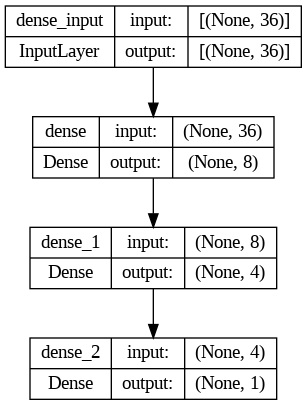

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 296       
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 337 (1.32 KB)
Trainable params: 337 (1.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss = "mean_squared_error", optimizer = "adam")

In [ ]:
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_test,y_test))

In [133]:
def model_builder(hp):
  model = keras.Sequential()

  hp_activation = hp.Choice('activation', values = ['relu', 'sigmoid'])
  hp_layer_1 = hp.Int('layer_1', min_value = 1, max_value = 10000, step = 100 )
  hp_layer_2 = hp.Int('layer_2', min_value = 1, max_value = 10000, step = 100 )
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

  model.add(Dense(units = hp_layer_1, activation = hp_activation))
  model.add(Dense(units = hp_layer_2, activation = hp_activation))
  model.add(Dense(1))

  model.compile(loss = "mean_squared_error",
                optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                metrics=['mean_squared_error'])

  return model

In [134]:
import keras_tuner as kt

In [138]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_mean_squared_error',
                     max_epochs = 10,
                     factor = 3,
                     directory = 'dir',
                     project_name = 'x')

Reloading Tuner from dir/x/tuner0.json


In [139]:
stop_early = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)

In [150]:
tuner.search(X_train, y_train, epochs = 50, validation_split=0.15, callbacks=[stop_early])

In [151]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hps

In [146]:
model = tuner.hypermodel.build(best_hps)

In [152]:
history = model.fit(X_train, y_train, epochs = 50, validation_split = 0.15, callbacks = [stop_early])

InternalError: ignored

In [147]:
plot_model(model, show_shapes=True, show_layer_names=True)

ValueError: ignored

In [148]:
model.summary()

ValueError: ignored

In [ ]:
test = pd.read_csv('testFS.csv', sep = ',')

In [ ]:
test = test.to_numpy()

In [ ]:
test.shape

(18657, 36)

In [ ]:
Y = model.predict(test)

584/584 [==============================] - 1s 2ms/step


In [ ]:
Y

array([[2004.2552],
       [1997.7281],
       [2003.0297],
       ...,
       [1994.2992],
       [2002.2611],
       [2001.8281]], dtype=float32)

In [ ]:
n = len(Y)
Ids = list(range(1, n + 1))

In [ ]:
Y = Y.flatten()

In [ ]:
df = pd.DataFrame({'Id': Ids, 'y': Y})

In [ ]:
csv_file_path = '/content/resultadosNN.csv'
df.to_csv(csv_file_path, index=False)

In [ ]:
indices = "20004 27910 46287 56236 27889 2110 34351 1149 63534 56917 27912 70100 6302 684 58650 27906 20833 27917 35504 24212 75247 2600 76361 66573 70098 65917 7742 44927 47553 62980 75249 36583 35867 68112 27892 253 46894 61005 42140 51351 36562 51356 24521 65953 44282 42132 17738 70738 1749 75660 18682 3005 16918 63321 58637 73061 33480 18710 51664 66356 42405 38623 74106 70103 34536 46010 35392 26412 24317 34772 14882 6309 24484 51798 14627 69898 65962 73172 21251 6157 39791 36565 42157 65956 64524 40261 19934 63322 19880 9078 42147 76339 37982 70101 76366 25559 14580 55418 42144 53569 34527 63622 9581 36572 36582 65944 36678 3475 54001 65943 27891 72784 51357 37668 52880 43019 24472 76252 36564 76341 53885 27880 56335 62673 15814 21033 54010 54004 50018 7152 9238 52196 13732 27890 27473 36563 37890 2302 73044 28783 49555 38917 24831 59776 51269 31397 60434 58816 48814 35267 5535 27015 45624 54539 48531 13737 34827 63660 15046 19933 19744 67070 11873 62730 41961 24488 52949 7965 31760 70097 2604 35858 19341 44811 26283 39484 64993 42127 54704 32961 36764 20787 5539 38686 9763 33746 15572 37682 36717 38417 38721 51950 7023 51669 7010 29697 48866 6337 2305 31801 3422 42139 13898 29367 46144 34831 36581 49473 9087 62439 18140 50011 52185 45619 75243 50470 66540 54257 49195 52194 65981 36138 5349 73727 18195 63809 40822 55483 27881 62442 54787 4402 55434 24510 67758 34826 54254 57807 34315 36578 50155 31795 68421 2971 60112 73723 60164 38227 4242 75285 24477 55424 32973 59816 53869 66572 46576 18919 52752 65644 65951 3016 28247 74113 17542 75259 20088 27897 27909 18689 20255 25624 46844 51125 41027 36585 55422 65047 55417 61466 27207 6395 54691 51410 361 70102 57601 9095 24578 18562 67006 75267 70099 49576 60400 36846 37396 45626 5571 26415 76353 75246 20160 26414 27193 7145 1527 49220 43648 56748 27614 18149 11852 50998 42520 41006 12173 7964 65942 35017 42155 72315 11004 34825 27911 36714 62678 11415 20005 6160 40824 19884 61205 75155 62608 43642 67769 58933 9023 19292 73726 76174 36589 76166 42161 42131 12682 70618 37966 60433 26288 44187 38466 51194 44837 43534 62123 71242 58836 360 33193 71044 15817 63318 73730 14381 3015 50327 16709 44810 1395 45520 27902 135 53992 74111 20506 37210 51877 27498 13735 70623 51464 35561 57808 33990 55472 47437 66566 33716 39068 15994 11849 61661 14377 5464 16691 16715 26286 3370 19932 77466 58758 51363 1483 10863 35868 44842 22558 53570 20089 44836 51352 22785 49900 9022 50081 46496 6696 14683 37166 71104 67797 17209 5347 45487 67482 42130 49578 16723 11881 68563 16922 1643 49906 19638 31496 60549 6335 32970 12888 34320 38258 8991 46580 44821 37934 40882 65889 77765 58649 34323 72674 55809 67720 44695 51593 63310 23147 16853 6552 10113 15693 41962 34305 49570 52134 4477 56759 47369 43205 32156 53985 33409 4407 77464 77465 70615 76295 54013 2181 15477 38488 65200 63297 54788 9012 50588 54711 66349 26427 65588 1985 44812 16851 42057 8282 72309 42642 55595 43988 42647 12178 44929 27975 45189 28448 38408 42133 29679 46856 36847 27877 20467 53825 42657 2743 75812 50061 9224 61017 7461 43202 7141 10550 27511 62130 74115 43147 16931 39774 447 3021 37675 7949 51765 18443 34836 44909 75148 63401 72986 6543 6646 63325 42149 30834 58647 31500 31714 57599 22608 43199 74938 9643 75149 20267 27262 58631 38487 9971 51901 70925 75628 37099 39067 36030 7746 26290 70453 37178 37366 19688 27507 34829 72998 36600 19553 54008 42137 75810 51195 36597 20082 62039 53715 24481 37801 4871 62666 24829 75260 25318 36559 43125 31638 65959 33484 77009 30460 53887 68166 12811 20621 26426 7148 54545 11420 9962 15051 34332 74112 63324 67756 53576 18706 20826 35854 52882 19093 56761 63413 30828 359 14378 27646 14246 40990 42515 75144 55419 23100 62131 29056 61512 27914 64390 43635 13285 4333 68851 9420 41054 53827 3376 49846 54537 40421 9764 72780 22411 62041 6073 36845 4308 48498 51761 5529 33090 16734 48191 54878 45199 62444 10541 5024 36579 45632 1265 40973 49806 7126 68938 8719 8365 62040 26408 43639 34858 22123 42129 65321 46826 6156 16930 29361 23887 12796 60446 62676 43201 67930 6821 56692 17995 10199 37375 19895 56685 14863 4311 38724 61787 63856 74528 26432 56543 33091 41046 12288 17128 32097 77467 51879 58941 18683 49993 6551 12662 65650 31772 41032 77002 71892 51270 41043 12076 63623 31898 16173 12067 5416 41018 59062 36566 25043 69306 26289 3022 27901 45924 11889 19056 14379 64823 40755 45179 75804 60014 18346 4309 77599 12929 1624 61817 67757 12699 10047 42516 10068 55460 26403 2993 74114 57004 49579 58932 65050 12650 64830 43198 43211 48807 23579 43197 71603 6785 75726 65948 40989 1308 15717 43195 13554 67771 57681 43409 77777 24834 56999 67933 47865 54974 36037 16921 65954 4232 6818 47344 46646 73584 36561 53890 36411 27904 41513 8614 27512 47442 6161 5577 58937 3582 37535 72964 58936 52059 31178 57815 52886 49789 19164 65977 33473 63769 72225 74188 53588 12832 12670 76472 19273 367 75575 45802 20007 58985 42151 36584 6556 21023 44846 37686 30833 35018 60114 41030 59777 16707 43229 62127 3165 4233 24698 48198 22557 43165 30463 36131 12877 10677 67353 33413 19033 48777 31781 36602 70907 63859 76243"
indices = indices.replace(' ', ',')
indices = indices.split(',')

dfIndices = pd.DataFrame({"Indice":indices})

In [ ]:
csv_file_path = '/content/indices.csv'
dfIndices.to_csv(csv_file_path, index=False)